In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import tensorflow as tf 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
cd C:\Users\ASUS\Desktop\dataset-460-40

C:\Users\ASUS\Desktop\dataset-460-40


In [5]:
import os
import json
from glob import glob
import numpy as np
from numpy import array
from numpy import argmax
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate, Masking, Multiply, Activation, Dense, Flatten

In [6]:
# from google.colab import drive
# drive.mount('/gdrive')

In [7]:
tf.random.set_seed(123)

### Data Preprocessing

In [8]:
def get_compiled_data(path):
    f_path = path
    f_list = sorted(glob(os.path.join(f_path, "*.json")))

    f_compile =[]

    for j in f_list: 
        file = open(j, "r")
        content = file.read()
        data = json.loads(content)
        f_compile.append(data)
    return f_compile

In [9]:
X = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x")
y = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y")
#X = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x/")
#y = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y/")

In [10]:
#Find min and max values of coordinates
coord_values = []
for i in range(len(X)):
  data = X[i] 
  for j in range(len(data)):
    data1 = data[j]
    for k in range(len(data1)):
      coord_values.append(data1[k])
print(min(coord_values))
print(max(coord_values))

0
499


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
print(len(X_train), len(y_train)) 

368 368


### Data Augmentation for X_train and y_train

In [13]:
# ##Data Augmentation (reverse seq)
# for i in range(len(X_train)):
#   compiled_x_reverse = X_train[i][::-1]
#   X_train.append(compiled_x_reverse)

# for i in range(len(y_train)):
#   compiled_y_reverse = y_train[i][::-1]
#   y_train.append(compiled_y_reverse)

In [14]:
# print(len(X_train))
# len(y_train)

In [15]:
# #Data Augmentation (translation by 5 units up and right)
# X_train_trans_aug_1 = [[[v+1 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_2 = [[[v+3 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_3 = [[[v+5 for v in inner1] for inner1 in inner] for inner in X_train]
# X_train_trans_aug_4 = [[[v+7 for v in inner1] for inner1 in inner] for inner in X_train]

In [16]:
# import copy
# y_train_trans_aug = copy.deepcopy(y_train)

In [17]:
# X_train.extend(X_train_trans_aug_1)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_2)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_3)
# y_train.extend(y_train_trans_aug)

# X_train.extend(X_train_trans_aug_4)
# y_train.extend(y_train_trans_aug)

In [18]:
# print(len(X_train), len(y_train)) 

Remove sequences with values above 499

In [19]:
compiled_x = []
compiled_y = []

for i, seq in enumerate(X_train):
  value_check=[]
  for _, coord in enumerate(seq):
    coord_01 = coord[0]
    coord_02 = coord[1]
    value_check.append(coord_01)
    value_check.append(coord_02)
  if max(value_check) < 500:
    compiled_x.append(seq)
    compiled_y.append(y_train[i])
    

In [20]:
print(len(compiled_x), len(compiled_y), len(X_valid), len(y_valid))

368 368 92 92


In [21]:
#For variable naming standardisation, "rename" X_valid to compiled_x_valid
compiled_x_valid = X_valid
compiled_y_valid = y_valid

### For encoder input (training)

In [22]:
encoder_input = []
for i in range(len(compiled_x)):
  data = compiled_x[i]   
  n = len(data)
  while len(data) < 267:                       
    data.append([500,500])                      
  encoder_input.append(data)

In [23]:
encoder_input = np.array(encoder_input)/500
encoder_input.shape

(368, 267, 2)

In [24]:
X1 = np.array(encoder_input)
X1.shape

(368, 267, 2)

In [25]:
encoder_input_valid = []
for i in range(len(compiled_x_valid)):
  data = compiled_x_valid[i]
  while  len(data)  < 267:                      
    data.append([500,500])                      
  encoder_input_valid.append(data)


In [26]:
encoder_input_valid = np.array(encoder_input_valid)/500
encoder_input_valid.shape

(92, 267, 2)

In [27]:
X1_valid = np.array(encoder_input_valid)
X1_valid.shape

(92, 267, 2)

### For decoder_target (training)

In [28]:
Y = []
for i in range(len(compiled_y)):
  data = compiled_y[i]                                   
  while len(data) < 267:                         
    data.append(2)
  Y.append(data)

In [29]:
Y = np.array(Y)
Y.shape

(368, 267)

In [30]:
Y = to_categorical([Y], num_classes=4)
Y.shape

(1, 368, 267, 4)

In [31]:
Y = Y.reshape(368, 267, 4)                  
Y.shape

(368, 267, 4)

### For decoder_target (validation)

In [32]:
Y_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i]                                   
  while len(data) < 267:                       
    data.append(2)
  Y_valid.append(data)

In [33]:
Y_valid = np.array(Y_valid)
Y_valid.shape

(92, 267)

In [34]:
Y_valid = to_categorical([Y_valid], num_classes=4)
Y_valid.shape

(1, 92, 267, 4)

In [35]:
Y_valid = Y_valid.reshape(92, 267, 4)  
Y_valid.shape

(92, 267, 4)

### For decoder input (shifted version of decoder target) - (training)

In [36]:
X2 = []
for i in range(len(compiled_y)):
  data = compiled_y[i] 
  while len(data) < 267:                         
    data.append(2)
  data = [3] + data[:-1]                         #? for indicating start of decoder input sequence (requirement for force teaching)
  X2.append(data)

In [37]:
X2 = np.array(X2)
X2.shape

(368, 267)

In [38]:
X2 = to_categorical([X2], num_classes=4)
X2.shape
X2 = X2.reshape(368, 267, 4)
X2.shape

(368, 267, 4)

### For decoder input (shifted version of decoder target) - (validation)

In [39]:
X2_valid = []
for i in range(len(compiled_y_valid)):
  data = compiled_y_valid[i] 
  while len(data) < 267:                        
    data.append(2)
  data = [3] + data[:-1]
  X2_valid.append(data)

In [40]:
X2_valid = np.array(X2_valid)
X2_valid.shape

(92, 267)

In [41]:
X2_valid = to_categorical([X2_valid], num_classes=4)
X2_valid.shape
X2_valid = X2_valid.reshape(92, 267, 4)  
X2_valid.shape

(92, 267, 4)

### Creation of test samples

In [42]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/x_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/x_test/")

In [43]:
encoder_input_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i] 
  while len(data) < 267:                         
    data.append([500,500])                      
  encoder_input_test.append(data)


In [44]:
encoder_input_test = np.array(encoder_input_test)/500
encoder_input_test.shape

(40, 267, 2)

In [45]:
X1_test = np.array(encoder_input_test)
X1_test.shape

(40, 267, 2)

In [46]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")

In [47]:
Y_test = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          
    data.append(2)
  Y_test.append(data)

In [48]:
Y_test = np.array(Y_test)
Y_test.shape

(40, 267)

In [49]:
Y_test = to_categorical([Y_test], num_classes=4)
Y_test.shape

(1, 40, 267, 4)

In [50]:
Y_test = Y_test.reshape(40, 267, 4)  
Y_test.shape

(40, 267, 4)

### Start of main program

Model built with bidirectional LSTM cell

In [51]:
def define_models(n_in, n_out, n_units):

    # define encoder
    enc_inputs = Input(shape=(None, n_in))
    encoder_inputs = Masking(mask_value=1.0)(enc_inputs) 
    encoder = Bidirectional(LSTM(n_units, return_state=True))   #Bidirectional LSTM
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]

    # define decoder
    dec_inputs = Input(shape=(None, n_out))
    decoder_inputs = Masking(mask_value=2)(dec_inputs) 
    decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)      #Multiple by 2 cuz of bidirectional
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_out, activation='sigmoid')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([enc_inputs, dec_inputs], decoder_outputs)

    # define inference encoder
    encoder_model = Model(enc_inputs, encoder_states)

    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units*2,))    #Multiple by 2 cuz of bidirectional
    decoder_state_input_c = Input(shape=(n_units*2,))    #Multiple by 2 cuz of bidirectional
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([dec_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    # return all models
    return model, encoder_model, decoder_model

In [52]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [53]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    
    return 1 - K.mean(f1)

In [54]:
# configure problem
import tensorflow as tf
n_features_input = 2
n_features_output = 4
n_units = 128

#from keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=15, min_lr=0.001)

# define model
train, infenc, infdec = define_models(n_features_input, n_features_output, n_units)

loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode='max', patience = 15, restore_best_weights=True)

train.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])

# generate training dataset
print(X1.shape,X2.shape,Y.shape)
# train model
history = train.fit([X1, X2], Y, batch_size=32, epochs=200, validation_data=([X1_valid, X2_valid],Y_valid),callbacks=[early_stop])

(368, 267, 2) (368, 267, 4) (368, 267, 4)
Epoch 1/200
12/12 [==============================] - 12s 350ms/step - loss: 1.2175 - acc: 0.6348 - precision: 0.4020 - recall: 0.8901 - f1: 0.3018 - val_loss: 0.8151 - val_acc: 0.8650 - val_precision: 0.5992 - val_recall: 0.9984 - val_f1: 0.3705
Epoch 2/200
12/12 [==============================] - 1s 87ms/step - loss: 0.5595 - acc: 0.7868 - precision: 0.6288 - recall: 0.9883 - f1: 0.3561 - val_loss: 0.4514 - val_acc: 0.8273 - val_precision: 0.6958 - val_recall: 0.9663 - val_f1: 0.3812
Epoch 3/200
12/12 [==============================] - 1s 86ms/step - loss: 0.4292 - acc: 0.8180 - precision: 0.6905 - recall: 0.9682 - f1: 0.3725 - val_loss: 0.3579 - val_acc: 0.8406 - val_precision: 0.7114 - val_recall: 0.9821 - val_f1: 0.3961
Epoch 4/200
12/12 [==============================] - 1s 85ms/step - loss: 0.3497 - acc: 0.8291 - precision: 0.6949 - recall: 0.9870 - f1: 0.3873 - val_loss: 0.3824 - val_acc: 0.8115 - val_precision: 0.6727 - val_recall: 0.96

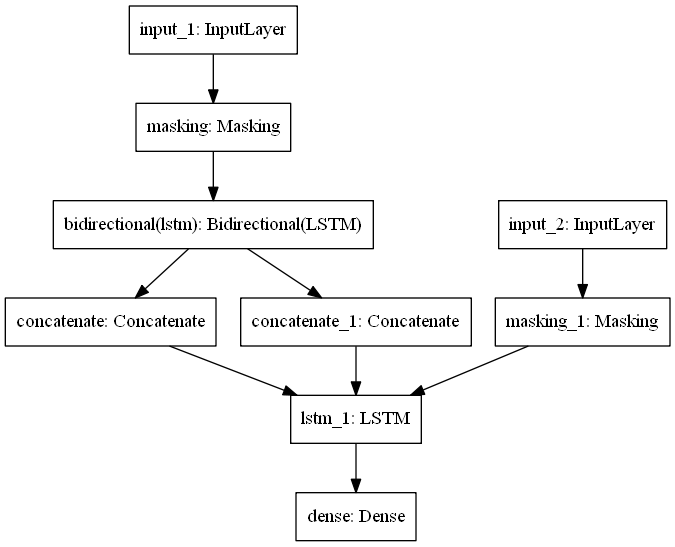

In [55]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(train,to_file='model.png')
#tf.keras.utils.plot_model(train,to_file='/content/model.png')

dict_keys(['loss', 'acc', 'precision', 'recall', 'f1', 'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'])


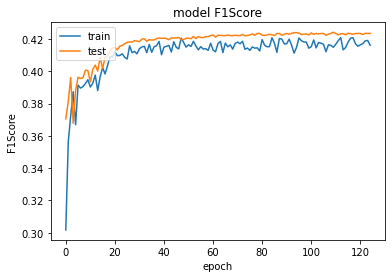

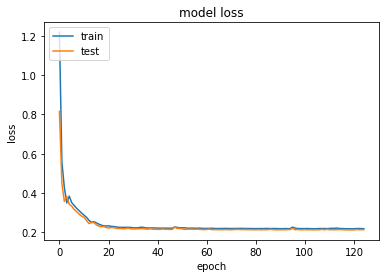

In [56]:
import matplotlib.pyplot as plt 
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# generate target given source sequence
def predict_sequence(infenc, infdec, input, n_steps_out, n_features): 
  #n_steps_out->no. of time-step in output
  #n_features->no. of features in output
	# encode
	state = infenc.predict([input])
	# start of sequence input
	target_seq = array([0.0 for _ in range(n_features)]).reshape(1, 1, n_features)
	# collect predictions
	output = list()
	for t in range(n_steps_out):
		# predict next char
		yhat, h, c = infdec.predict([[target_seq] + state])
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

In [58]:
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

### Evaluate with test sample

In [ ]:
prediction= []
n_features=4
n_steps_out = 267
for i in range(X1_test.shape[0]):
  test = X1_test[i]
  test = test[newaxis,:, :]
  pred = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
  pred = one_hot_decode(pred)
  prediction.extend(pred)

In [ ]:
compiled_data = get_compiled_data("C:/Users/ASUS/Desktop/system_code/dataset-460-40/y_test")
#compiled_data = get_compiled_data("/gdrive/MyDrive/dataset-460-40/y_test/")

In [ ]:
truth = []
for i in range(len(compiled_data)):
  data = compiled_data[i]                                   
  while len(data) < 267:                          
    data.append(2)
  truth.extend(data)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

### Examine single test sample

In [ ]:
test = X1_test[0]
test.shape
test = test[newaxis,:, :]
test.shape

In [ ]:
n_features=4
n_steps_out = 267
prediction = predict_sequence(infenc, infdec, test, n_steps_out, n_features)
prediction = one_hot_decode(prediction)
prediction = np.array(prediction)

In [ ]:
truth = Y_test[0]
truth = one_hot_decode(truth)
truth = np.array(truth)

In [ ]:
matrix = confusion_matrix(truth, prediction, labels=[0,1,2])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1,2]))

In [ ]:
prediction

In [ ]:
truth